In [1]:
import pandas as pd
import joblib
from data_processing.main import read_scoreset
from tqdm import tqdm
from pathlib import Path
from data_processing.mapping_nbs import mapping_utils
from data_processing.mapping_nbs import plotting
pd.set_option('display.max_columns', 500)

dataset_name = "Mighell_PTEN_lipidPhosphataseAssay"
dataset_path = Path("/data/dzeiberg/mave_calibration/data/") / dataset_name
assert dataset_path.exists()

In [2]:
metadata, gene_info, gnomAD_df, spliceAI_df, clinvar_df = mapping_utils.load_mapping_data()

In [4]:
scoreset = pd.read_csv(dataset_path / "scoreset.csv").assign(synonymous=False)
scoreset = scoreset.assign(nonsense=scoreset.hgvs_pro.str.slice(-3) == "Ter")

In [5]:
scoreset

,accession,hgvs_nt,hgvs_splice,hgvs_pro,score,SE,High_conf,A_score,A_SE,B_score,B_SE,A1_score,A1_SE,A2_score,A2_SE,A3_score,A3_SE,B1_score,B1_SE,B2_score,B2_SE,B3_score,B3_SE,author_transcript,synonymous,nonsense
0,urn:mavedb:00000054-a-1#3,c.1208_1209delinsAA,NaN,p.Val403Glu,0.193065,0.180809,1.0,0.348556,0.142215,-1.220374,0.567749,0.174396,0.183904,0.218258,0.194469,0.592867,0.150122,-2.786450,1.447358,-1.311838,0.872876,-0.559310,0.872879,NM_000314.6,False,False
1,urn:mavedb:00000054-a-1#9,c.1208_1209delinsGT,NaN,p.Val403Gly,-2.736793,0.828697,0.0,NaN,NaN,-2.736793,0.828697,NaN,NaN,0.493526,1.032800,-0.019169,1.032799,-3.238435,1.435344,-2.862236,1.435345,-2.109707,1.435347,NM_000314.6,False,False
2,urn:mavedb:00000054-a-1#15,c.1207_1209delinsTGG,NaN,p.Val403Trp,-2.459162,0.832588,0.0,NaN,NaN,-2.459162,0.832588,NaN,NaN,NaN,NaN,NaN,NaN,-2.960803,1.442084,-2.584604,1.442085,-1.832076,1.442087,NM_000314.6,False,False
3,urn:mavedb:00000054-a-1#18,c.[1207G>A;1209C>G],NaN,p.Val403Met,0.106511,0.063560,1.0,0.106511,0.063560,NaN,NaN,0.166644,0.109310,0.111688,0.119667,0.049131,0.103138,NaN,NaN,NaN,NaN,NaN,NaN,NM_000314.6,False,False
4,urn:mavedb:00000054-a-1#20,c.[1207G>A;1209C>T],NaN,p.Val403Ile,-2.049575,0.909505,0.0,NaN,NaN,-2.049575,0.909505,NaN,NaN,-0.094261,0.942814,1.429927,0.556045,-0.960285,0.351302,-3.628408,1.424000,-2.875880,1.424002,NM_000314.6,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,urn:mavedb:00000054-a-1#8669,c.1_3delinsTGT,NaN,p.Met1Cys,1.181219,0.298849,1.0,NaN,NaN,1.181219,0.298849,NaN,NaN,NaN,NaN,NaN,NaN,0.583450,0.394800,1.632270,0.418682,1.333904,0.344656,NM_000314.6,False,False
8008,urn:mavedb:00000054-a-1#8674,c.1_2delinsTG,NaN,p.Met1Trp,-1.300060,0.432320,1.0,NaN,NaN,-1.300060,0.432320,NaN,NaN,NaN,NaN,NaN,NaN,-0.824046,0.429695,-2.205445,1.432110,-1.781877,0.580532,NM_000314.6,False,False
8009,urn:mavedb:00000054-a-1#8675,c.1_3delinsTAT,NaN,p.Met1Tyr,-0.872034,0.286561,1.0,-1.100501,0.539142,-0.812891,0.409667,-3.003794,1.440035,-0.563236,0.477435,-1.375100,0.860684,-3.003829,1.444500,-0.578965,0.868147,-0.634770,0.490737,NM_000314.6,False,False
8010,urn:mavedb:00000054-a-1#8678,c.1A>T,NaN,p.Met1Leu,-1.545614,0.883483,0.0,NaN,NaN,-1.545614,0.883483,NaN,NaN,NaN,NaN,NaN,NaN,-3.087210,1.442090,-0.151521,0.692861,-2.184489,0.864111,NM_000314.6,False,False


In [6]:
if "author_transcript" not in scoreset.columns or scoreset.author_transcript.isna().all():
    AUTHOR_TRANSCRIPT = gene_info.loc[metadata.loc[dataset_name],'MANE_RefSeq_nuc'].values[0].split(".")[0]
else:
    AUTHOR_TRANSCRIPT = scoreset.author_transcript.iloc[0].split(".")[0]

In [7]:
AUTHOR_TRANSCRIPT

'NM_000314'

# Add ClinVar annotations

In [8]:
clinvar_hgvs_pro_summaries = mapping_utils.get_clinvar_summaries(clinvar_df,AUTHOR_TRANSCRIPT)

100%|██████████| 1321/1321 [00:00<00:00, 2236.61it/s]


In [9]:
scoreset_w_clinvar = pd.merge(scoreset.set_index("hgvs_pro"),clinvar_hgvs_pro_summaries,
                            left_index=True,
                            right_index=True,
                            how="left",
                            validate="one_to_one",
                            suffixes=("","_clinvar"))

# Add gnomAD annotations

In [10]:
Ensembl_transcript_stable_ids = mapping_utils.translate_refseq_to_ensembl(AUTHOR_TRANSCRIPT)

In [11]:
Ensembl_transcript_stable_ids

array(['ENST00000644628', 'ENST00000371953'], dtype=object)

In [12]:
gnomAD_info = mapping_utils.gather_gnomAD_info(gnomAD_df,Ensembl_transcript_stable_ids,[AUTHOR_TRANSCRIPT,])

In [13]:
scoreset_processed = pd.merge(scoreset_w_clinvar,gnomAD_info,
                                        left_index=True,right_index=True,how="left",validate="one_to_one").reset_index()

In [14]:
scoreset_processed

,hgvs_pro,accession,hgvs_nt,hgvs_splice,score,SE,High_conf,A_score,A_SE,B_score,B_SE,A1_score,A1_SE,A2_score,A2_SE,A3_score,A3_SE,B1_score,B1_SE,B2_score,B2_SE,B3_score,B3_SE,author_transcript,synonymous,nonsense,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max,gnomAD_variants_maxAC_AF,gnomAD_variants_max_spliceAI_score,gnomAD_variants_VCF_INFO
0,p.Val403Glu,urn:mavedb:00000054-a-1#3,c.1208_1209delinsAA,NaN,0.193065,0.180809,1.0,0.348556,0.142215,-1.220374,0.567749,0.174396,0.183904,0.218258,0.194469,0.592867,0.150122,-2.786450,1.447358,-1.311838,0.872876,-0.559310,0.872879,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Val403Gly,urn:mavedb:00000054-a-1#9,c.1208_1209delinsGT,NaN,-2.736793,0.828697,0.0,NaN,NaN,-2.736793,0.828697,NaN,NaN,0.493526,1.032800,-0.019169,1.032799,-3.238435,1.435344,-2.862236,1.435345,-2.109707,1.435347,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,p.Val403Trp,urn:mavedb:00000054-a-1#15,c.1207_1209delinsTGG,NaN,-2.459162,0.832588,0.0,NaN,NaN,-2.459162,0.832588,NaN,NaN,NaN,NaN,NaN,NaN,-2.960803,1.442084,-2.584604,1.442085,-1.832076,1.442087,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,p.Val403Met,urn:mavedb:00000054-a-1#18,c.[1207G>A;1209C>G],NaN,0.106511,0.063560,1.0,0.106511,0.063560,NaN,NaN,0.166644,0.109310,0.111688,0.119667,0.049131,0.103138,NaN,NaN,NaN,NaN,NaN,NaN,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,p.Val403Ile,urn:mavedb:00000054-a-1#20,c.[1207G>A;1209C>T],NaN,-2.049575,0.909505,0.0,NaN,NaN,-2.049575,0.909505,NaN,NaN,-0.094261,0.942814,1.429927,0.556045,-0.960285,0.351302,-3.628408,1.424000,-2.875880,1.424002,NM_000314.6,False,False,0.0,0.0,0.0,1.0,NM_000314.8(PTEN):c.1207G>A (p.Val403Ile),1.0,0.01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8007,p.Met1Cys,urn:mavedb:00000054-a-1#8669,c.1_3delinsTGT,NaN,1.181219,0.298849,1.0,NaN,NaN,1.181219,0.298849,NaN,NaN,NaN,NaN,NaN,NaN,0.583450,0.394800,1.632270,0.418682,1.333904,0.344656,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8008,p.Met1Trp,urn:mavedb:00000054-a-1#8674,c.1_2delinsTG,NaN,-1.300060,0.432320,1.0,NaN,NaN,-1.300060,0.432320,NaN,NaN,NaN,NaN,NaN,NaN,-0.824046,0.429695,-2.205445,1.432110,-1.781877,0.580532,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8009,p.Met1Tyr,urn:mavedb:00000054-a-1#8675,c.1_3delinsTAT,NaN,-0.872034,0.286561,1.0,-1.100501,0.539142,-0.812891,0.409667,-3.003794,1.440035,-0.563236,0.477435,-1.375100,0.860684,-3.003829,1.444500,-0.578965,0.868147,-0.634770,0.490737,NM_000314.6,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8010,p.Met1Leu,urn:mavedb:00000054-a-1#8678,c.1A>T,NaN,-1.545614,0.883483,0.0,NaN,NaN,-1.545614,0.883483,NaN,NaN,NaN,NaN,NaN,NaN,-3.087210,1.442090,-0.151521,0.692861,-2.184489,0.864111,NM_000314.6,False,False,1.0,0.0,0.0,0.0,NM_000314.8(PTEN):c.1A>T (p.Met1Leu),1.0,0.00,NaN,NaN,NaN


In [15]:
scoreset_processed.to_csv(dataset_path / "scoreset_processed.csv",index=False)

# Reload Processed

In [8]:
scoreset_processed = pd.read_csv(dataset_path / "scoreset_processed.csv")

In [16]:
def conflicting_interpretations(r):
    """
    Check if a record has conflicting interpretations
    P/LP and B/LB ; P/LP and VUS ; B/LB and VUS ; P/LP and conflicting ; B/LB and conflicting
    If data is mapped at the protein level, this could be a result of different RNA substitutions
    If data is mapped at the RNA level, this is a true conflict

    Parameters
    ----------
    r : pd.Series
        A record from the ClinVar data frame

    Returns
    -------
    bool
        True if there are conflicting interpretations, False otherwise
    """
    return r.num_p_lp > 0 and r.num_b_lb > 0 or \
            r.num_p_lp > 0 and r.num_VUS > 0 or \
            r.num_b_lb > 0 and r.num_VUS > 0 or \
            r.num_p_lp > 0 and r.num_conflicting > 0 or \
            r.num_b_lb > 0 and r.num_conflicting > 0


def is_pathogenic(r):
    return r.num_p_lp > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_benign(r):
    return r.num_b_lb > 0 and not conflicting_interpretations(r) and r.clinvar_spliceAI_max <= .5

def is_vus(r):
    return r.num_VUS > 0

def is_conflicting(r):
    return r.num_conflicting > 0

def is_gnomAD(r):
    return r.gnomAD_variants_maxAC_AF > 0 and r.gnomAD_variants_max_spliceAI_score <= .5

def is_synonymous(r):
    return r.synonymous and r.num_p_lp == 0 and r.clinvar_spliceAI_max <= .5



In [17]:
sample_data = {
    "P/LP" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_pathogenic(r),axis=1)],
    "B/LB" : scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_benign(r),axis=1)],
    'gnomAD': scoreset_processed[scoreset_processed.apply(lambda r: not r.nonsense and is_gnomAD(r),axis=1)],
    'synonymous' : scoreset_processed[scoreset_processed.apply(is_synonymous,axis=1)],
}
sample_data = {k : v for k,v in sample_data.items() if len(v)}

INVERT_SCORES = False
if INVERT_SCORES:
    for k in sample_data:
        sample_data[k] = sample_data[k].assign(score= -sample_data[k].score)

In [18]:
for sample_name, sample in sample_data.items():
    print(f"{sample_name}: {sample.shape[0]}")

P/LP: 182
B/LB: 5
gnomAD: 221


(<Figure size 1200x900 with 3 Axes>,
 array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>], dtype=object))

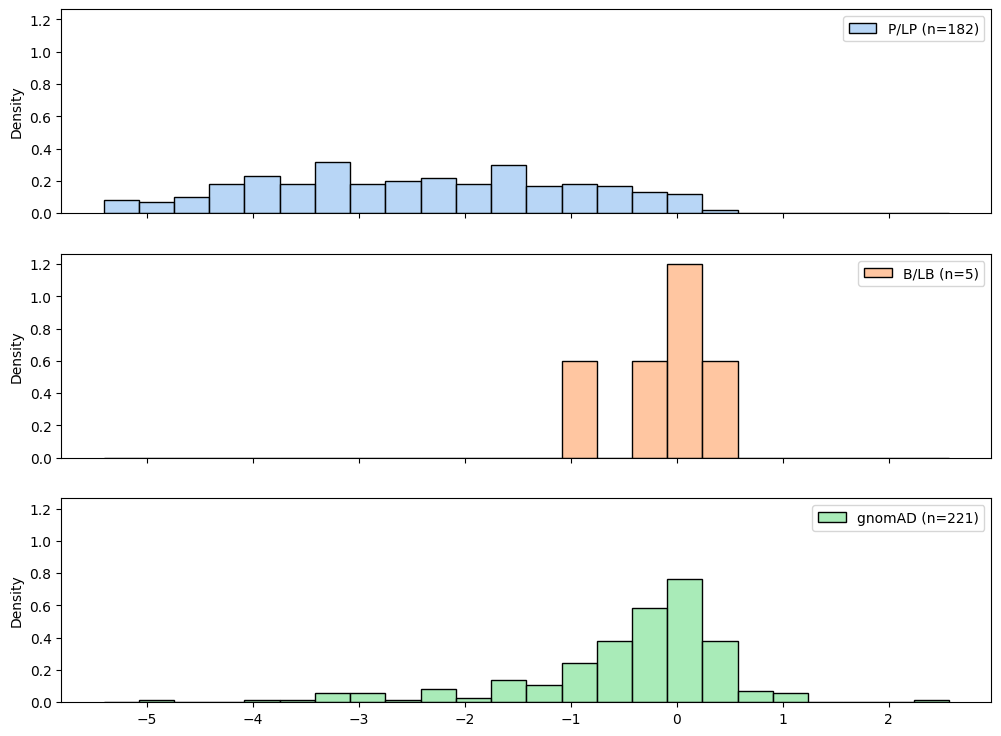

In [19]:
plotting.plot_samples({k : v.score.values for k,v in sample_data.items()})

In [21]:
if 'synonymous' in sample_data:
    
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                                *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                                *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values],
                                *[dict(sample_name='synonymous',score=score) for score in sample_data['synonymous'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)
else:
    pd.DataFrame.from_records([*[dict(sample_name='P/LP',score=score) for score in sample_data['P/LP'].score.values],
                                *[dict(sample_name='B/LB',score=score) for score in sample_data['B/LB'].score.values],
                                *[dict(sample_name='gnomAD',score=score) for score in sample_data['gnomAD'].score.values]]).to_csv(dataset_path / "samples.csv",index=False)

In [22]:
old = joblib.load(dataset_path / "hgvs_pro.pkl")

In [23]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['p_lp'].values) - set(sample_data['P/LP'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
p.Arg159Ser,1,0,0,1,NM_000314.8(PTEN):c.477G>T (p.Arg159Ser)|NM_00...,2,0.25
p.Asn276Ser,1,0,0,0,NM_000314.8(PTEN):c.827A>G (p.Asn276Ser),1,0.62
p.Asp310Gly,1,0,0,0,NM_000314.8(PTEN):c.929A>G (p.Asp310Gly),1,0.96
p.Gly129Val,1,0,0,0,NM_000314.8(PTEN):c.386G>T (p.Gly129Val),1,0.85
p.Ile135Val,1,0,0,0,NM_000314.8(PTEN):c.403A>G (p.Ile135Val),1,0.64
p.Leu112Val,1,0,0,0,NM_000314.8(PTEN):c.334C>G (p.Leu112Val),1,0.85
p.Lys267Asn,1,0,1,0,NM_000314.8(PTEN):c.801G>T (p.Lys267Asn)|NM_00...,2,0.41
p.Lys342Asn,1,0,0,1,NM_000314.8(PTEN):c.1026G>C (p.Lys342Asn)|NM_0...,2,0.51
p.Met134Ile,2,0,0,1,NM_000314.8(PTEN):c.402G>T (p.Met134Ile)|NM_00...,3,0.00


In [24]:
clinvar_hgvs_pro_summaries[clinvar_hgvs_pro_summaries.index.isin(set(old['b_lb'].values) - set(sample_data['B/LB'].hgvs_pro.values))]

,num_p_lp,num_b_lb,num_conflicting,num_VUS,clinvar_names,clinvar_records,clinvar_spliceAI_max
hgvs_pro,,,,,,,
